In [237]:
import os
from datetime import date, timedelta
import datetime as dt

from collections import Counter
import ast
import yt.wrapper as yt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [200]:
def read_df_from_hahn(table_path):
    """
    reads table from YT Hahn unto pd.DataFrame, converts dates
    table_path:  path in Hahn
    """
    yt.config["proxy"]["url"] = "hahn.yt.yandex.net"
    client = yt.YtClient(proxy="hahn", config={"tabular_data_format": "dsv"})
    read_result = yt.read_table(table_path, raw=False)
    raw_data = [row for row in read_result.rows]
    dataframe = pd.DataFrame(raw_data)
    for col in dataframe.columns:
        if col in ['activation_date', 'field_date', 'first_day']:
            dataframe[col] = pd.to_datetime(dataframe[col])
    return dataframe

def add_time_delta(date, day_range=1):
    day_range_added = (dt.datetime.strptime(date, "%Y-%m-%d") + dt.timedelta(days=day_range)).strftime("%Y-%m-%d")
    return day_range_added


def get_table_range(date, day_range=1):
    day_range_ago = add_time_delta(date, day_range)
    if day_range < 0:
        return "{" + day_range_ago + ".." + date + "}"
    else:
        return "{" + date + ".." + day_range_ago + "}"

def filter_df(df, cur_scenario, app="total", min_date="2021-04-01", max_date="2021-05-31"):
    df = df[np.logical_and(np.logical_and(df.scenario == cur_scenario, df.fielddate <= max_date), df.fielddate >= min_date)].reset_index()
    if app == "total":
        df = df[["fielddate", "devices", "weekly_devices", "total_timespent_m"]].groupby("fielddate").sum().reset_index()
    else:
        df = df[["fielddate", "devices", "weekly_devices", "total_timespent_m"]][df.app == app].reset_index()
    return df

def map_yoy_date(fielddate):
    return (dt.datetime.strptime(fielddate, "%Y-%m-%d") - dt.timedelta(days=364)).strftime("%Y-%m-%d")

In [217]:
TIMESPENT_TABLE = "//home/alice/precomputes/timespent/total_timespent"
CURRENT_YEAR = "//home/voice/polinakud/VA_1982_weekly_scale/current_year"
LAST_YEAR = "//home/voice/polinakud/VA_1982_weekly_scale/last_year"

Devices const weekly/week avg: 1.1440795612024708
Daily yoy const ts/user 2021/2020: 0.9300429338704175


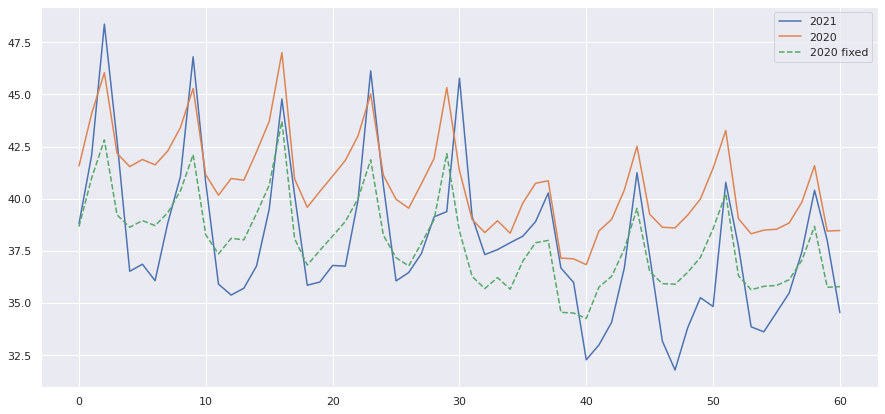

Weekly ts const 2021/2020: 0.9282294870532748 
  for 2021: sum(daily ts)/weekly devices 
  for 2020: sum(daily ts)/(const * (mean daily devices)) 


In [238]:
def calculate_yoy_constant(df, scenario, min_date="2021-04-01", max_date="2021-05-31"):
    '''
    scenario + dates for constant evaluation
    joins last year and current year data
    computes different metrics ratio
    prints result
    '''
    current = filter_df(read_df_from_hahn(CURRENT_YEAR), scenario, min_date=min_date, max_date=max_date)
    last_year = filter_df(read_df_from_hahn(LAST_YEAR), scenario, min_date=map_yoy_date(min_date), max_date=map_yoy_date(max_date))
    last_year['join_date'] = last_year.fielddate.apply(lambda x: add_time_delta(x, 364))
    df = current.join(last_year.set_index('join_date'),  how='inner', on='fielddate', lsuffix="_l", rsuffix="_r")
    devices_const = np.mean(df.weekly_devices[6:]/np.convolve(df.devices_l, np.ones(7)/7, mode="valid"))
    print(f"Devices const weekly/week avg: {devices_const}")
    daily_ts_const = np.mean((df.total_timespent_m_l/df.devices_l)/(df.total_timespent_m_r/df.devices_r))
    print(f"Daily yoy const ts/user 2021/2020: {daily_ts_const}")
    plt.figure(figsize=(15,7))
    plt.plot(df.total_timespent_m_l/df.devices_l, label="2021")
    plt.plot(df.total_timespent_m_r/df.devices_r, label="2020")
    plt.plot(daily_ts_const*df.total_timespent_m_r/df.devices_r, label="2020 fixed", linestyle="--")
    plt.legend()
    plt.show()
    weekly_2021 = (np.convolve(df.total_timespent_m_l, np.ones(7), mode="valid")/df.weekly_devices[6:])
    weekly_2020 = np.convolve(df.total_timespent_m_r, np.ones(7), mode="valid")/(devices_const*np.convolve(df.devices_r, np.ones(7)/7, mode="valid"))
    wekkly_ts_const = np.mean(weekly_2021/weekly_2020)
    print(f"Weekly ts const 2021/2020: {wekkly_ts_const} \n  for 2021: sum(daily ts)/weekly devices \n  for 2020: sum(daily ts)/(const * (mean daily devices)) ")

CURRENT_SCENARIO = "music"
calculate_yoy_constant(df, CURRENT_SCENARIO)

Devices const weekly/week avg: 1.1440795612024708
Daily yoy const ts/user 2021/2020: 1.148540745968009


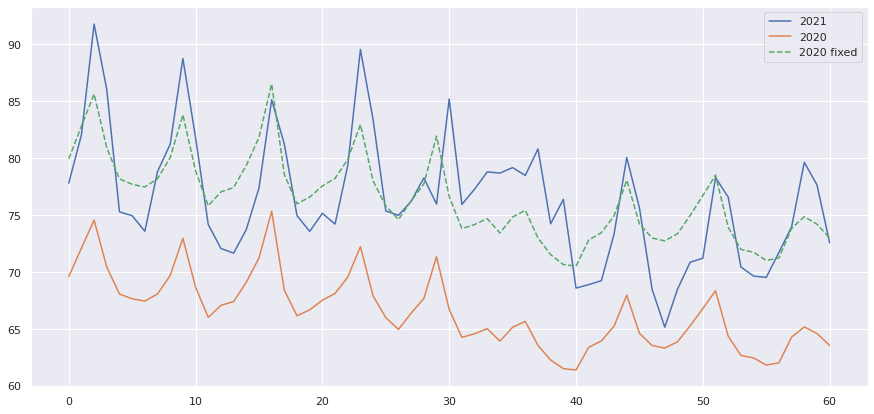

Weekly ts const 2021/2020: 1.147027602738042 
  for 2021: sum(daily ts)/weekly devices 
  for 2020: sum(daily ts)/(const * (mean daily devices)) 


In [239]:
calculate_yoy_constant(df, "_total_")